In [ ]:
import os
# os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np
import imageio

In [ ]:
from octo.model.octo_model import OctoModel
from octo.utils.train_utils import merge_params

pretrained_model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small")


2024-05-28 20:37:05.587264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 20:37:05.587314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 20:37:05.588596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 20:37:06.593748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# print(pretrained_model.perturbations)
from flax.traverse_util import flatten_dict 
print(flatten_dict(pretrained_model.perturbations).keys())

dict_keys([('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_0_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_1_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_2_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_3_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_4_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_5_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_6_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_7_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_8_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_9_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_10_out'), ('octo_transformer', 'BlockTransformer_0', 'Transformer_0', 'layer_11_out')])


In [ ]:
from ml_collections import ConfigDict
from ml_collections.config_dict import FieldReference, placeholder
from octo.model.components.action_heads import MSEActionHead
from octo.model.components.tokenizers import BinTokenizer, LowdimObsTokenizer, ImageTokenizer, UnsqueezingImageTokenizer, ProjectionTokenizer, SiglipTokenizer
from octo.model.components.vit_encoders import SmallStem16

from octo.utils.spec import ModuleSpec

def get_config(config_string=None):
    # config_string = "full,language_conditioned"
    config_string = "full,multimodal"
    mode, task = config_string.split(",")
    assert task in ["image_conditioned", "language_conditioned", "multimodal"]
    assert mode in ["full", "head_only", "head_mlp_only"]

    # Fill this in for your own dataset!

    # There should be two image keys
    # first image key should be the third-person view (None if not used)
    # and second image key should be the wrist view (None if not used)
    CAMS_ONLY = True 

    FINETUNING_KWARGS = {
        "name": "bridge_dataset:1.0.0",
        "data_dir": "/home/joshwajones/tensorflow_datasets/",
        "image_obs_keys": {
            "primary": "image_0",
        },
        "digit_obs_keys": {}, # TODO: remove this, treating digits just as images
        "proprio_obs_key": None, # "state",
        "sensor_obs_keys": {},
        "language_key": "language_instruction",
        # We want to avoid normalizing the gripper
        "action_normalization_mask": [True, True, True, True, True, True, False],
        # standardize_fn is dynamically loaded from a file
        # for example: "experiments/kevin/custom_standardization_transforms.py:aloha_dataset_transform"
        "standardize_fn": ModuleSpec.create(
            "octo.data.oxe.oxe_standardization_transforms:bridge_dataset_transform",
        ),
        
        # If the default data loading speed is too slow, try these:
        # "num_parallel_reads": 8,  # for reading from disk / GCS
        # "num_parallel_calls": 16,  # for initial dataset construction
    }
    if not CAMS_ONLY: 
        digit_names = { 
            "digit_left": "digit_0",
            "digit_right": "digit_1",   
        }
        FINETUNING_KWARGS["image_obs_keys"].update(digit_names)

        sensor_names = { 
            "spectro": "mel_spectro",
            "imu": "imu",
            "digit_0_embedding": "digit_0_embedding", 
            "digit_1_embedding": "digit_1_embedding",
        }
        FINETUNING_KWARGS["sensor_obs_key"].update(sensor_names)



    # NEW_OBS_TOKENIZERS = { 
    #     "digits": 
    #         ModuleSpec.create(
    #             ImageTokenizer,
    #             obs_stack_keys=["image_digit_left", "image_digit_right"],
    #             task_stack_keys=[],
    #             encoder=ModuleSpec.create(SmallStem16),
    #         ),
    #     "spectrogram": 
    #         ModuleSpec.create( 
    #             UnsqueezingImageTokenizer,
    #             obs_stack_keys = ["spectro"], 
    #             task_stack_keys=[], 
    #             encoder=ModuleSpec.create(SmallStem16),
    #         ),
    #     "imu": ModuleSpec.create( 
    #             ProjectionTokenizer,
    #             num_output_tokens=7,
    #             n_bins=256,
    #             obs_keys=["imu"], 
    #         ),
    #    "digit_embeddings": ModuleSpec.create( 
    #             ProjectionTokenizer,
    #             num_output_tokens=7,
    #             n_bins=256,
    #             obs_keys=["digit_0_embedding", "digit_1_embedding"], 
    #         ),
    #     "siglip": {
    #             "freeze": False, # True, 
    #             "config": { 
    #                 'encoder_path':'/home/sjosh/nfs/octo_digit/siglip.npz:img', # '/home/joshwajones/octo/siglip.npz:img',
    #                 'image_model': 'vit', 
    #                 'image': dict(variant='B/16', pool_type='map')
    #             }
    #         }, 
    # }
    NEW_OBS_TOKENIZERS = {}

    NEW_ACTION_HEAD = None 
    NEW_ACTION_HEAD = ModuleSpec.create(
        MSEActionHead,
        readout_key="readout_action",
        use_map = False, # should this be disabled? 
        action_horizon=4,
        action_dim=7
    )
    
        


    if mode == "full":
        frozen_keys = None
    elif mode == "head_only":
        frozen_keys = ("octo_transformer.*",)
    elif mode == "head_mlp_only":
        frozen_keys = (
            "octo_transformer.*",
            "heads_*.map_head.probe",
            "heads_*.map_head.MultiHeadDotProductAttention_0.*",
        )
    elif mode == "frozen_transformer":
        frozen_keys = ("octo_transformer.BlockTransformer_0.*",)
    else:
        raise ValueError("Invalid mode")

    max_steps = FieldReference(50000)
    # max_steps = FieldReference(25000)
    window_size = FieldReference(default=2)

    config = dict(
        pretrained_path="hf://rail-berkeley/octo-small",
        batch_size=256,
        shuffle_buffer_size=10000,
        num_steps=max_steps,
        log_interval=100,
        eval_interval=2500,
        save_interval=5000,
        # save_dir="/home/joshwajones/octo_save_dir/",
        save_dir="gs://619c8f721786ba/octo_ckpts/",
	seed=42,
        wandb=dict(
            project="octo", group=placeholder(str), entity=placeholder(str)
        ),
        dataset_kwargs=FINETUNING_KWARGS,
        modality=task,
        finetuning_mode=mode,
        window_size=window_size,
        optimizer=dict(
            learning_rate=dict(
                name="cosine",
                init_value=0.0,
                peak_value=3e-4,
                warmup_steps=2000,
                decay_steps=max_steps,
                end_value=0.0,
            ),
            weight_decay=0.01,
            clip_gradient=1.0,
            frozen_keys=frozen_keys,
            grad_accumulation_steps=None,  # if you are using grad accumulation, you need to adjust max_steps accordingly
        ),
        val_kwargs=dict(
            val_shuffle_buffer_size=1000,
            num_val_batches=16,
        ),
        viz_kwargs=dict(
            eval_batch_size=64,
            trajs_for_metrics=100,
            trajs_for_viz=8,
            samples_per_state=8,
        ),
        gradcam_kwargs=dict( 
            eval_batch_size=4, 
            shuffle_buffer_size=1000, 
            train=False, 
            gradcam_kwargs_list=(
                    ('obs_primary', {'psuedo_loss_type': 'loss'}),
                    ('obs_wrist', {'psuedo_loss_type': 'loss'})
            )
        )
    )

    if "siglip" in NEW_OBS_TOKENIZERS: 
        should_freeze, siglip_cfg = NEW_OBS_TOKENIZERS["siglip"]["freeze"], NEW_OBS_TOKENIZERS["siglip"]["config"]
        config["siglip_config"] = siglip_cfg
        NEW_OBS_TOKENIZERS["siglip"] = ModuleSpec.create( 
                    SiglipTokenizer,
                    image=siglip_cfg["image"],
                    image_model=siglip_cfg["image_model"],
                    encoder_path=siglip_cfg["encoder_path"],
                    n_bins=256,
                    obs_keys=['siglip'],
        )

        if should_freeze: 
            prev_frozen = frozen_keys if frozen_keys else ()
            config["optimizer"]["frozen_keys"] = prev_frozen + ("octo_transformer.observation_tokenizers_siglip.*", "*hf_model*")


    if task == "image_conditioned":
        goal_relabeling_strategy = "uniform"
        keep_image_prob = 1.0
    elif task == "language_conditioned":
        goal_relabeling_strategy = None
        keep_image_prob = 0.0
    elif task == "multimodal":
        goal_relabeling_strategy = "uniform"
        keep_image_prob = 0.5
    else:
        raise ValueError("Invalid modality")


    traj_transform_kwargs = dict(
        window_size=window_size,
        action_horizon=4,
        goal_relabeling_strategy=goal_relabeling_strategy,
        task_augment_strategy="delete_task_conditioning",
        task_augment_kwargs=dict(
            keep_image_prob=keep_image_prob,
        ),
        # If the default data loading speed is too slow, try these:
        # num_parallel_calls=16,  # for less CPU-intensive ops
    )

    workspace_augment_kwargs = dict(
        random_resized_crop=dict(scale=[0.8, 1.0], ratio=[0.9, 1.1]),
        random_brightness=[0.1],
        random_contrast=[0.9, 1.1],
        random_saturation=[0.9, 1.1],
        random_hue=[0.05],
        augment_order=[
            "random_resized_crop",
            "random_brightness",
            "random_contrast",
            "random_saturation",
            "random_hue",
        ],
    )
    wrist_augment_kwargs = dict(
        random_brightness=[0.1],
        random_contrast=[0.9, 1.1],
        random_saturation=[0.9, 1.1],
        random_hue=[0.05],
        augment_order=[
            "random_brightness",
            "random_contrast",
            "random_saturation",
            "random_hue",
        ],
    )
    digit_augment_kwargs = dict(
        random_resized_crop=dict(scale=[0.8, 1.0], ratio=[0.9, 1.1]),
        augment_order=[
            "random_resized_crop"
        ],
    )
    frame_transform_kwargs = dict(
        resize_size={
            "primary": (256, 256),  # workspace (3rd person) camera is at 256x256
            "wrist": (128, 128),   # wrist camera is at 128x128
            "digit_left": (256, 256), #(128, 128),
            "digit_right": (256, 256),  # (128, 128)
        },
        image_augment_kwargs = { 
            "primary": workspace_augment_kwargs, 
            "wrist": wrist_augment_kwargs, 
            "digit_left": digit_augment_kwargs,
            "digit_right": digit_augment_kwargs,
        }
    )
    # If the default data loading speed is too slow, try these:
    config[
        "frame_transform_threads"
    ] = 16  # for the most CPU-intensive ops (decoding, resizing, augmenting)

    config["traj_transform_kwargs"] = traj_transform_kwargs
    config["frame_transform_kwargs"] = frame_transform_kwargs
    config["new_obs_tokenizers"] = NEW_OBS_TOKENIZERS

    config['update_config'] = { 
        "model":  {
            "repeat_task_tokens": True,
        }
    }
    if NEW_ACTION_HEAD is not None: 
        config['update_config']['model']['heads'] = { 
            'action': ConfigDict(NEW_ACTION_HEAD)
        } 
    config['update_config'] = ConfigDict(config['update_config'])

    return ConfigDict(config)

CONFIG = get_config(None)
FLAGS = { 
    "name": "experiment", 
    "debug": True, 
    "config": CONFIG, 
} 
FLAGS = ConfigDict(FLAGS)


## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [ ]:
trajnum = 0
import tensorflow as tf
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ds = builder.as_dataset(split=f'train[{trajnum}:{trajnum+1}]')

# sample episode + resize to 256x256 (default third-person cam resolution)

episode = next(iter(ds))
steps = list(episode['steps'])

images = [
    tf.image.resize(
                np.array(step['observation']['image']), size=(256, 256), method="lanczos3", antialias=True
            ) for step in steps
]
images =   [tf.cast(tf.clip_by_value(tf.round(image), 0, 255), tf.uint8) for image in images] 
# images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]


# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()


2024-05-28 20:38:06.134764: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [ ]:
actions = [
    np.concatenate(
        (
            step['action']['world_vector'], 
            step['action']['rotation_delta'], 
            np.array(step['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ) for step in steps
]

ACTION_HORIZON = 4 
action_hs = [] 
action_pads = [] 
for i in range(len(actions) - ACTION_HORIZON + 1): 
    action_h = np.stack(actions[i:i+ACTION_HORIZON])
    action_hs.append(action_h)

    action_pads.append(np.full(action_h.shape, True))


In [ ]:
# visualize episode
STEP_DURATION = 0.2 
print(f'Instruction: {language_instruction}')
save_path = './viz_vid.mp4'
video = np.stack(images)
imageio.mimsave(save_path, video, fps=1.0 / STEP_DURATION * 3)

Instruction: Place the can to the left of the pot.


## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [ ]:
WINDOW_SIZE = 2

# create `task` dict
# task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
language_instruction = 'Grab the eggplant.'
task = pretrained_model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [ ]:
def create_batch(step, task): 
    batch = {} 
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    batch['observation'] = observation
    batch['task'] = task
    input_acs = np.stack(action_hs[step:step+WINDOW_SIZE])[None]
    input_ac_pads = np.stack(action_pads[step:step+WINDOW_SIZE])[None]
    batch['action'] = input_acs 
    batch['action_pad_mask'] = input_ac_pads
    return batch 


In [ ]:
example_batch = create_batch(0, task)
rng = jax.random.PRNGKey(FLAGS.config.seed)
rng, init_rng = jax.random.split(rng)
text_processor = pretrained_model.text_processor
config = pretrained_model.config
if 'wrist' in config["model"]["observation_tokenizers"]:
    del config["model"]["observation_tokenizers"]["wrist"]
config['model']['repeat_task_tokens'] = False
config['model']['use_correct_attention'] = False
model = OctoModel.from_config(
    config,
    example_batch,
    text_processor,
    rng=init_rng,
    dataset_statistics=pretrained_model.dataset_statistics['bridge_dataset'],
)
merged_params = merge_params(model.params, pretrained_model.params)
model = model.replace(params=merged_params)


In [ ]:
print(model.module.octo_transformer.observation_tokenizers)

{'primary': ImageTokenizer(
    # attributes
    encoder = {'module': 'octo.model.components.vit_encoders', 'name': 'SmallStem16', 'args': [], 'kwargs': {}}
    use_token_learner = False
    num_tokens = 8
    conditioning_type = 'none'
    obs_stack_keys = ['image_primary']
    task_stack_keys = ['image_primary']
    task_film_keys = ()
    proper_pad_mask = True
)}


In [ ]:
from octo.utils.train_utils import (
    check_config_diff,
    create_optimizer,
    format_name_with_config,
    merge_params,
    process_text,
    Timer,
    TrainState,
)
params = model.params
tx, lr_callable, param_norm_callable = create_optimizer(
    params,
    **FLAGS.config.optimizer.to_dict(),
)
train_state = TrainState.create(
    model=model,
    tx=tx,
    rng=rng,
)



In [ ]:

# rng, dropout_rng = jax.random.split(train_state.rng)
# from octo.utils.gradcam import gradCAM, visualize_img_and_gradcam
# %matplotlib inline
# # rng = jax.random.PRNGKey(0)
# # rng, dropout_rng = jax.random.split(rng)
# # dropout_rng = jax.random.PRNGKey(1)

# original_image, resized_gradcam = gradCAM(
#     model, model.params, model.perturbations, 'obs_primary', batch, dropout_rng, rng=rng, psuedo_loss_type='loss'
# )
# visualize_img_and_gradcam(original_image, resized_gradcam)
# # model.perturbations
# # from flax.traverse_util import flatten_dict
# # flat = flatten_dict(model.perturbations)
# # for val in flat.values(): 
# #     print(val.shape)

In [ ]:
rng, dropout_rng = jax.random.split(train_state.rng)
from octo.utils.gradcam import gradCAM, visualize_img_and_gradcam, get_overlaid_attention_map

language_instruction = 'Move the can to the left of the pot.'
task = model.create_tasks(texts=[language_instruction])   

viz_every = 5
logs = [] 
for step in tqdm.trange(len(images) - (max(WINDOW_SIZE, ACTION_HORIZON) - 1)):
    if step % viz_every == 0: 
        batch = create_batch(step, task)
        original_image, resized_gradcam = gradCAM(
            model, model.params, model.perturbations, 'obs_primary', batch, dropout_rng, rng=rng, psuedo_loss_type='loss'
        )
        # visualize_img_and_gradcam(original_image, resized_gradcam)
        attn_map = get_overlaid_attention_map(original_image, resized_gradcam, blur=True)
        logs.append((original_image, attn_map))



100%|██████████| 35/35 [00:24<00:00,  1.42it/s]


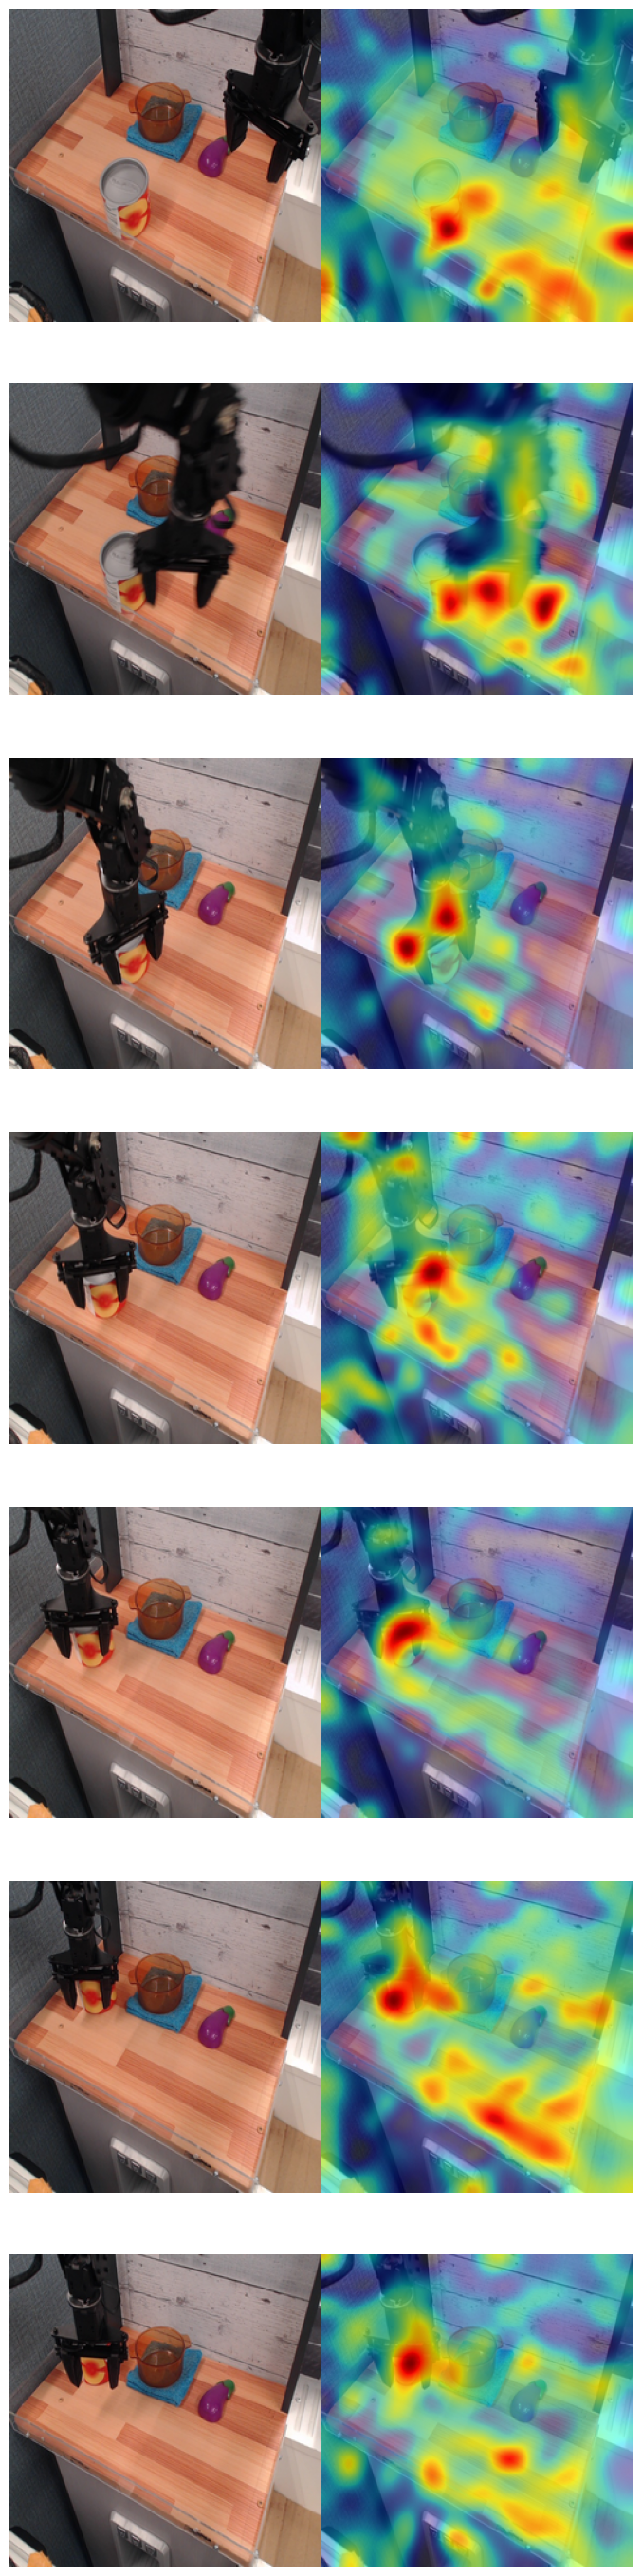

In [ ]:
#   _, axes = plt.subplots(1, 2, figsize=(10, 5))
#     axes[0].imshow(img)
#     axes[1].imshow(get_overlaid_attention_map(img, attn_map, blur))
#     for ax in axes:
#         ax.axis("off")
#     plt.show()
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(len(logs), 1, figsize=(10, 5 * len(logs)))
for i, (img, attn) in enumerate(logs): 
    h, w = img.shape[:2]
    frame = np.zeros((h, 2 * w, 3))
    frame[:, :w, :] = img /255.0
    frame[:, w:, :] = attn 
    axes[i].imshow(frame)
    axes[i].axis('off')
    # axes[i, 0].imshow(img)
    # axes[i, 0].axis('off')
    # axes[i, 1].imshow(attn)
    # axes[i, 1].axis('off')
plt.show() 
# fig.savefig(f'./gradcam_{trajnum}.png')

In [ ]:
# fig.savefig(f'./gradcam_3.png', pad_inches=0, bbox_inches='tight')

In [ ]:
model.module.octo_transformer.use_correct_attention

False